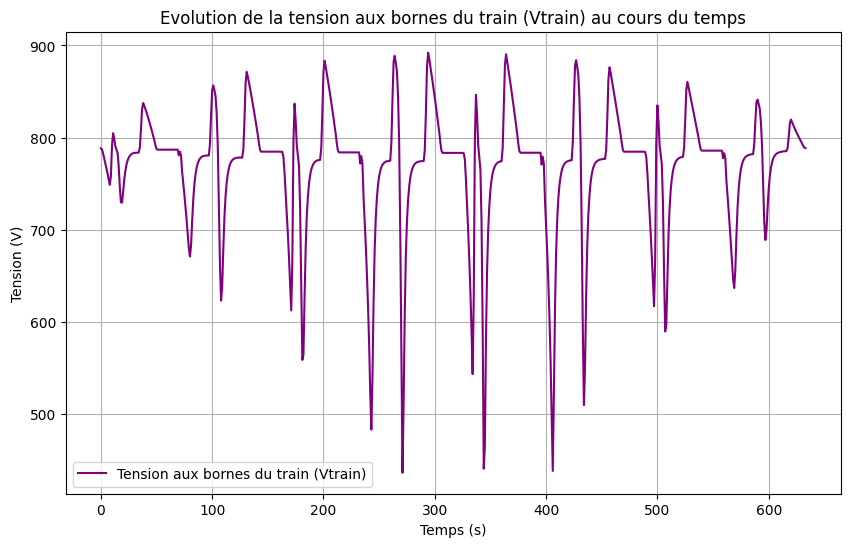

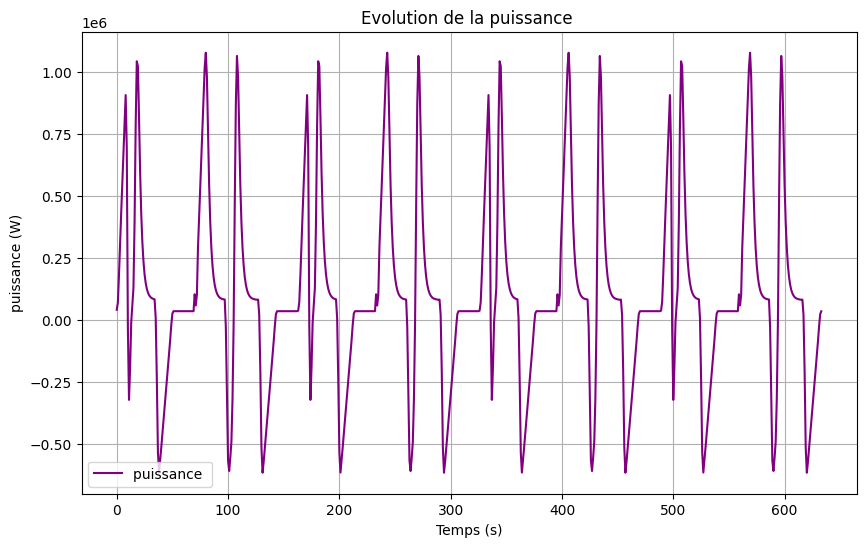

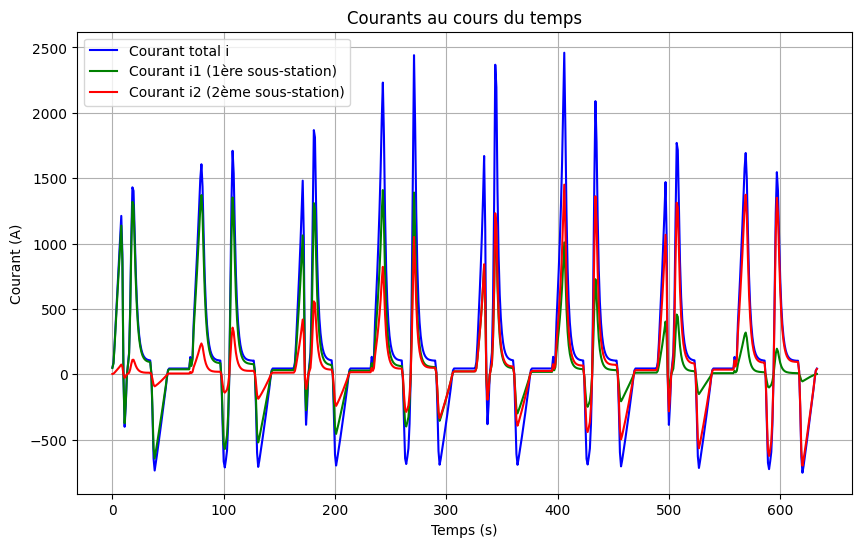

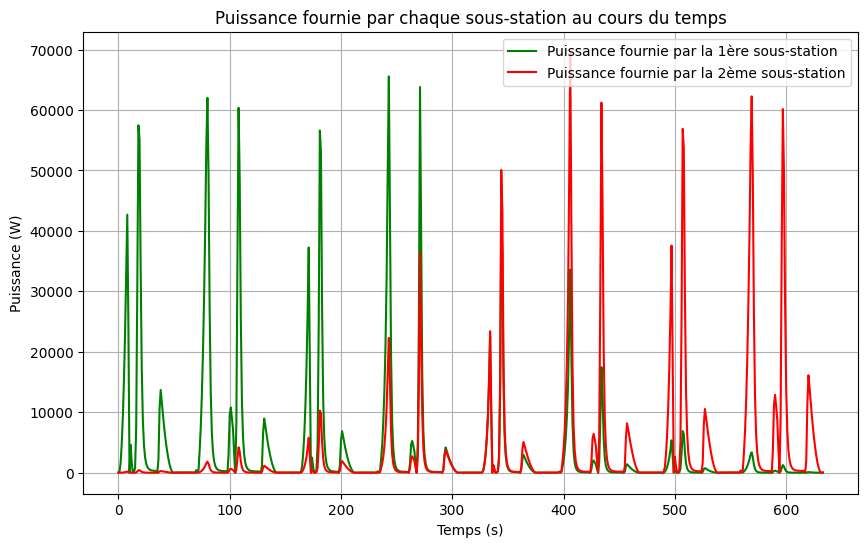

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour calculer RLAC et Rrail
def calculer_RLAC(x):
    return RLAC_per_m * x

def calculer_Rrail(x):
    return Rrail_per_m * x

# Fonction pour calculer Req
def calculer_Req(x):
    RLAC1 = calculer_RLAC(x)
    Rrail1 = calculer_Rrail(x)
    RLAC2 = calculer_RLAC(5000 - x)  # Longueur totale de 5 km
    Rrail2 = calculer_Rrail(5000 - x)
    R1 = RLAC1 + Rrail1 + Rsst
    R2 = RLAC2 + Rrail2 + Rsst
    return ( (R1*R2)/(R1 + R2 ) )

# Fonction pour calculer la puissance mécanique
def calculer_puissance_mecanique(temps, position_x):
    vitesse = np.gradient(position_x, temps)
    acceleration = np.gradient(vitesse, temps)

    # Paramètres pour le calcul de la force résistive
    M = 70000 
    Ao = 780
    A1 = 6.4
    Bo = 0
    B1 = 0.14
    Co = 0.3634
    C1 = 0

    # Force résistive
    Fresistive = (Ao + A1 * M/1000) + (Bo + B1 * M/1000) * 3.6*vitesse + (Co + C1 * M/1000) * (3.6*vitesse)**2

    # Force motrice
    Fmotrice = M * acceleration + M * 9.81 * np.sin(0) + Fresistive  # En supposant une pente nulle pour le moment

    Pmechanique = Fmotrice * vitesse
    return Pmechanique


# Données du problème
Vsst = 790  
Rsst = 33e-3  
RLAC_per_m = 95e-6  
Rrail_per_m = 10e-6  

# Charger les données de la marche du train
data = np.loadtxt('marche_train.txt')  
temps = data[:, 0]
position_x = data[:, 1] 

Pmechanique = calculer_puissance_mecanique(temps, position_x)



Ptrain = []
for p_mechanique in Pmechanique:
    if p_mechanique >= 0:
        Ptrain.append(p_mechanique / 0.80 + 35000)
    else:
        Ptrain.append(p_mechanique * 0.80 + 35000)
  
  

# 1. Calcul de Vtrain
Vtrain = []
for idx in range(len(temps)):
    x = position_x[idx]
    Req = calculer_Req(x)
    P = Ptrain[idx]
    delta = Vsst**2 - 4 * Req * P
    if delta >= 0:
        V = 0.5 * (Vsst + np.sqrt(delta))
        Vtrain.append(V)
    else:
        Vtrain.append(np.nan)

# 2. Calcul des courants et des puissances (en dehors de la boucle de Vtrain)
i  = []
i1 = []
i2 = []
P1 = []
P2 = []

for idx in range(len(temps)):
    x = position_x[idx]
    Req = calculer_Req(x)
    P = Ptrain[idx]
    V = Vtrain[idx]
    i_value = (Vsst - V) / Req
    i.append(i_value)
    # Calcul des courants i1 et i2
    i1_value = (Vsst - V) / (Rsst + calculer_RLAC(x) + calculer_Rrail(x))
    i2_value = (Vsst - V) / (Rsst + calculer_RLAC(5000 - x) + calculer_Rrail(5000 - x))
    P1_value = (Rsst ) * i1_value**2 
    P2_value = (Rsst ) * i2_value**2 
    i1.append(i1_value)
    i2.append(i2_value)
    P1.append(P1_value)
    P2.append(P2_value)

# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.plot(temps, Vtrain, label='Tension aux bornes du train (Vtrain)', color='purple')
plt.title('Evolution de la tension aux bornes du train (Vtrain) au cours du temps')
plt.xlabel('Temps (s)')
plt.ylabel('Tension (V)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(temps, Ptrain, label='puissance ', color='purple')
plt.title('Evolution de la puissance ')
plt.xlabel('Temps (s)')
plt.ylabel('puissance (W)')
plt.legend()
plt.grid(True)
plt.show()

# Tracer les courants (i, i1, i2)
plt.figure(figsize=(10, 6))
plt.plot(temps, i, label='Courant total i', color='blue')
plt.plot(temps, i1, label='Courant i1 (1ère sous-station)', color='green')
plt.plot(temps, i2, label='Courant i2 (2ème sous-station)', color='red')
plt.title('Courants au cours du temps')
plt.xlabel('Temps (s)')
plt.ylabel('Courant (A)')
plt.legend()
plt.grid(True)
plt.show()

# Tracer les puissances (P1 et P2)
plt.figure(figsize=(10, 6))
plt.plot(temps, P1, label='Puissance fournie par la 1ère sous-station', color='green')
plt.plot(temps, P2, label='Puissance fournie par la 2ème sous-station', color='red')
plt.title('Puissance fournie par chaque sous-station au cours du temps')
plt.xlabel('Temps (s)')
plt.ylabel('Puissance (W)')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
def gestion_puissances(P_seuil, train_demand, battery_level, battery_capacity, battery_output_capacity, battery_input_capacity, Dt=1, battery_efficiency=0.9):
    P_LAC = 0.0
    P_battery = 0.0
    P_rheostat = 0.0
    
    # Phase de consommation élevée (accélération ou forte demande)
    if train_demand >= P_seuil:
        # Puissance cible que la batterie doit fournir :
        target_battery_power = train_demand - P_seuil
        max_battery_power = min(battery_output_capacity, battery_level / Dt)
        requested_discharge = min(target_battery_power, max_battery_power)

        # The actual power delivered to the train is battery_efficiency * requested_discharge
        # but to keep consistent with the usage in controlling flows, we treat P_battery as
        # the power "seen" from the system perspective.
        # We'll handle the battery_level update with efficiency separately.
        P_battery = requested_discharge
                
        # Si la batterie ne peut pas fournir toute la différence, on ajuste la LAC :
        if P_battery < target_battery_power:
            # Complément de puissance à fournir par la LAC
            P_LAC = P_seuil + (target_battery_power - P_battery)
        else:
            # La batterie couvre entièrement la différence : la LAC fournit uniquement P_seuil
            P_LAC = P_seuil
        
        # Dans tous les cas, le rhéostat ne consomme pas ici
        P_rheostat = 0






    elif 0 < train_demand < P_seuil:
        # Demande modérée : la LAC couvre cette demande entièrement
        P_LAC = train_demand
        P_battery = 0
        P_rheostat = 0


    else:
        # train_demand <= 0 --> récupération d'énergie vers la batterie ou dissipation
        P_LAC = 0
        if battery_level < battery_capacity:
            # Propose de stocker |train_demand| dans la batterie dans la limite de battery_input_capacity et de battery_level
            proposed_battery_power = max(train_demand, -battery_input_capacity / Dt)
            new_energy_if_charged = battery_level + (-proposed_battery_power * Dt * battery_efficiency)


            if new_energy_if_charged > battery_capacity:
                max_charge = battery_capacity - battery_level
                P_battery = -max_charge / (Dt*battery_efficiency)
                P_rheostat = -(train_demand - P_battery)

            else:
                P_battery = proposed_battery_power
                if (P_battery == -battery_input_capacity) or (P_battery == -battery_level / Dt):
                    P_rheostat = -(train_demand - P_battery)
                else:
                    P_rheostat = 0
                
        else:
            # Batterie pleine
            P_battery = 0
            P_rheostat = -train_demand


    if P_battery > 0:
        # Discharging: from battery's perspective, it must supply P_battery / battery_efficiency
        battery_level -= (P_battery / battery_efficiency) * Dt
    else:
        # Charging (P_battery <= 0): battery gains -P_battery * battery_efficiency
        battery_level += (-P_battery * battery_efficiency) * Dt


    # On devrait pas dépasser la capacité de la batterie MAIS BON .... 
    if battery_level > battery_capacity:
        print(battery_level)
        battery_level = battery_capacity
        print("heyyyyyyyyyyy c pas normal cughl agi !!!")
        print(str(battery_level) + '\n')
        
        
        
    return P_battery, P_LAC, P_rheostat, battery_level


In [3]:
# Parametres du probleme
battery_capacity = 5e6  # en J
P_seuil = 0.5e6 # en W


# Details
battery_level = battery_capacity*0.5     # J
battery_output_capacity = battery_capacity / 10.0  # W
battery_input_capacity = battery_capacity / 10.0   # W
Dt = 1 # en s

# Liste pour stocker les résultats de la batterie
P_battery_list = []
P_LAC_list = []
P_rheostat_list = []
battery_levels = []


# Boucle de simulation pour chaque point de données
for t in range(len(Ptrain)):
    p = Ptrain[t]
    P_battery, P_LAC, P_rheostat, battery_level = gestion_puissances(P_seuil, p, battery_level, battery_capacity, battery_output_capacity, battery_input_capacity, Dt)
    
    P_battery_list.append(P_battery)
    P_LAC_list.append(P_LAC)
    P_rheostat_list.append(P_rheostat)
    battery_levels.append(battery_level)



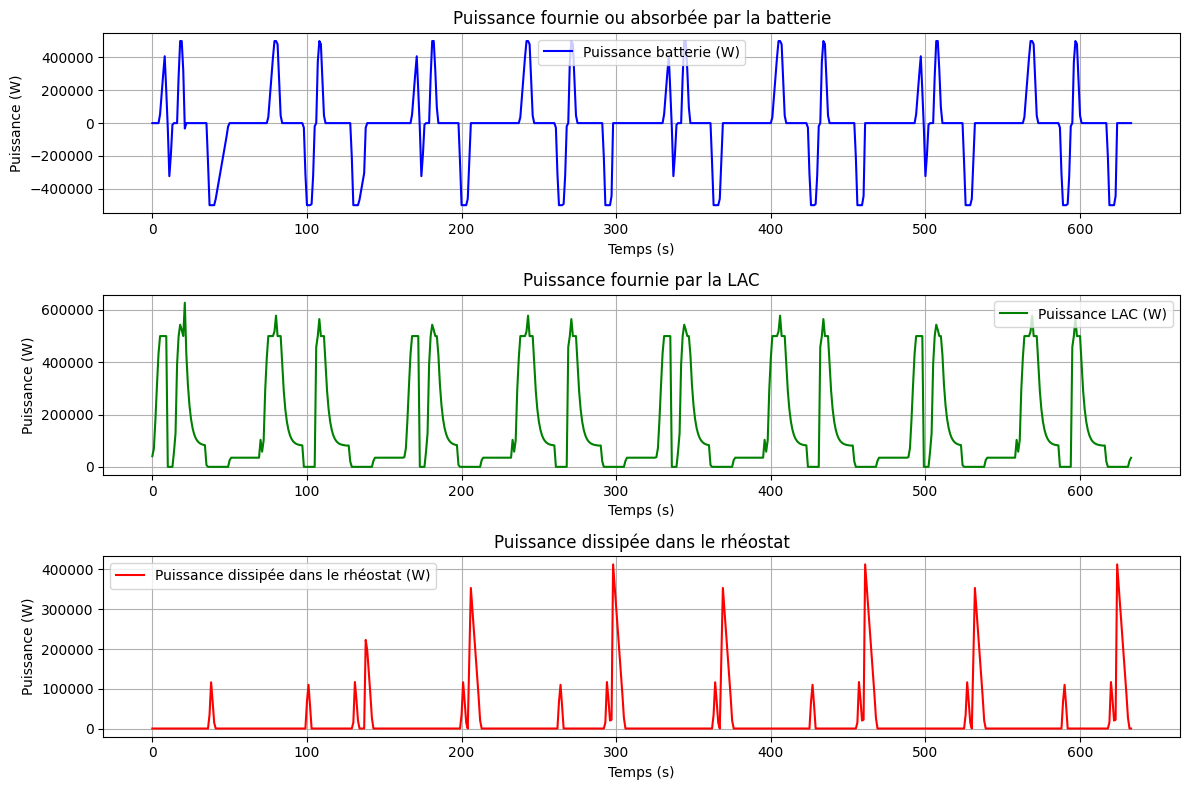

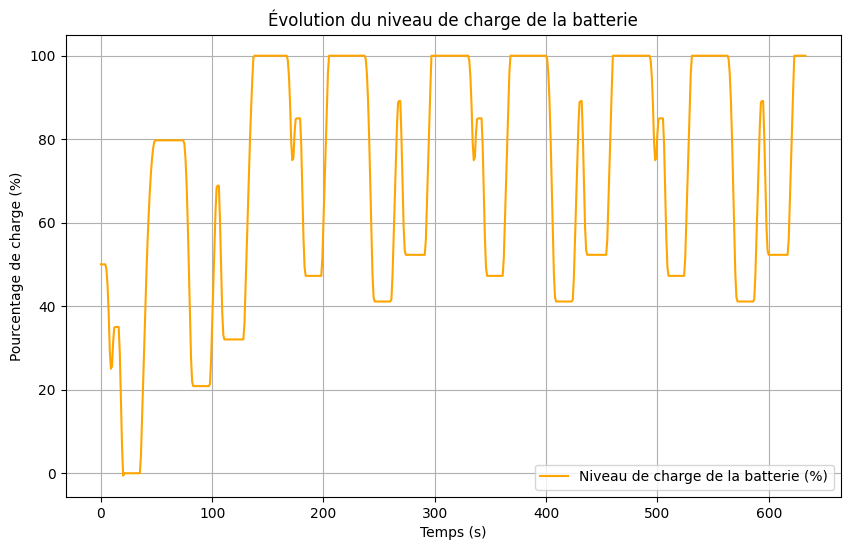

In [4]:
# AFFICHAGE
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(temps, P_battery_list, label='Puissance batterie (W)', color='blue')
plt.title('Puissance fournie ou absorbée par la batterie')
plt.xlabel('Temps (s)')
plt.ylabel('Puissance (W)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(temps, P_LAC_list, label='Puissance LAC (W)', color='green')
plt.title('Puissance fournie par la LAC')
plt.xlabel('Temps (s)')
plt.ylabel('Puissance (W)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(temps, P_rheostat_list, label='Puissance dissipée dans le rhéostat (W)', color='red')
plt.title('Puissance dissipée dans le rhéostat')
plt.xlabel('Temps (s)')
plt.ylabel('Puissance (W)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


battery_levels_np = np.array(battery_levels)
battery_prctg = 100 * battery_levels_np / battery_capacity

plt.figure(figsize=(10, 6))
plt.plot(temps, battery_prctg, label='Niveau de charge de la batterie (%)', color='orange')
plt.title('Évolution du niveau de charge de la batterie')
plt.xlabel('Temps (s)')
plt.ylabel('Pourcentage de charge (%)')
plt.legend()
plt.grid(True)
plt.show()

# MONTE CARLO

In [5]:
from tqdm import tqdm
def monte_carlo_iteration(
    capacity_range,
    P_seuil_range,
    gestion_puissances,
    temps,
    position_x,
    Ptrain,
    Vsst,
    calculer_Req,
    Dt
):    
    
    battery_capacity = np.random.uniform(capacity_range[0], capacity_range[1])
    P_seuil = np.random.uniform(P_seuil_range[0], P_seuil_range[1])
    
    battery_output_capacity = battery_capacity * 0.1
    battery_input_capacity = battery_capacity * 0.1
    
    battery_level = battery_capacity / 2.0
    chute_de_tension_list = []
    

    for idx in range(len(temps)):
        x = position_x[idx]
        train_demand = Ptrain[idx]
        
        RCeq = calculer_Req(x)
        
        P_battery, P_LAC, P_rheostat, battery_level = gestion_puissances(
            P_seuil,
            train_demand,
            battery_level,
            battery_capacity,
            battery_output_capacity,
            battery_input_capacity,
            Dt
        )
        
        delta = Vsst**2 - 4 * RCeq * P_LAC
        if delta >= 0:
            Vtrain = 0.5 * (Vsst + np.sqrt(delta))
        else:
            Vtrain = 0
            
        chute_tension = Vsst - Vtrain
        chute_de_tension_list.append(chute_tension)
    
    chute_de_tension_max = max(chute_de_tension_list)
    return (battery_capacity, P_seuil, chute_de_tension_max)


def run_monte_carlo(n_iterations, capacity_range, P_seuil_range, *args):
    results = []
    
    for _ in tqdm(range(n_iterations), desc="Monte Carlo Iterations"):
        result = monte_carlo_iteration(capacity_range, P_seuil_range, *args)
        results.append(result)
        
    return results


capacity_range = (0, 50000000)  # in Joules
P_seuil_range = (0, 1000000)     # in Watts
n_iterations = 1000

# Run Monte Carlo simulation
results = run_monte_carlo(
    n_iterations,
    capacity_range,
    P_seuil_range,
    gestion_puissances,
    temps,
    position_x,
    Ptrain,
    Vsst,
    calculer_Req,
    Dt
)

Monte Carlo Iterations: 100%|██████████| 1000/1000 [00:02<00:00, 363.00it/s]


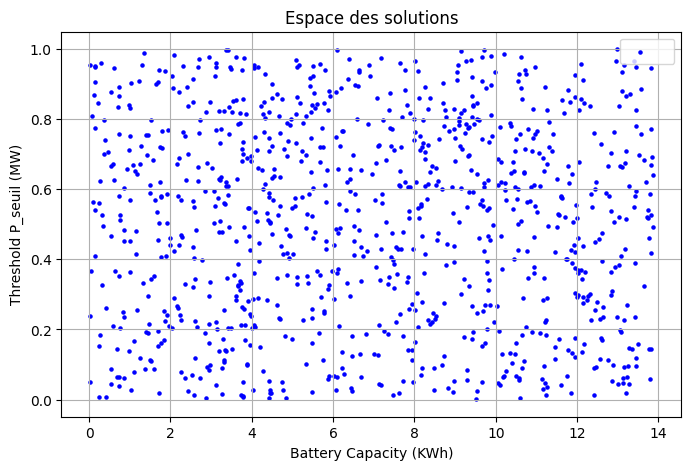

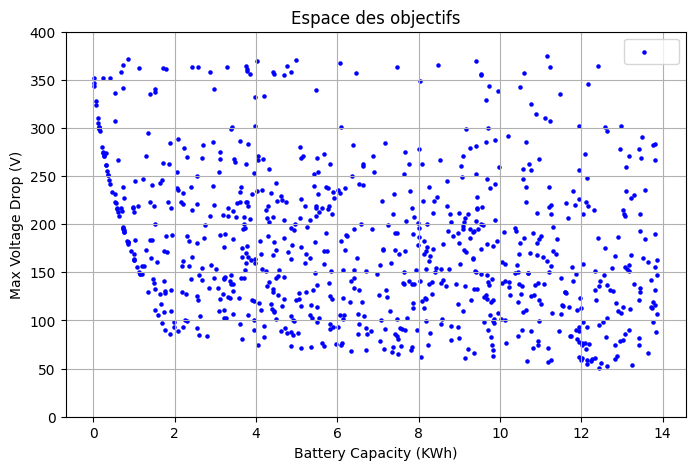

In [6]:
def plot_results(results):
    capacities = [item[0] for item in results]
    p_seuils = [item[1] for item in results]
    voltage_drops = [item[2] for item in results]
    
    capacities_kWh = np.array(capacities) / (3600 * 1000.0)
    p_seuils_MW = np.array(p_seuils) / 1e6
    # -----------------------------------
    # Figure 1: Plot of P_seuil vs. capacity
    # -----------------------------------
    plt.figure(figsize=(8, 5))
    plt.scatter(capacities_kWh, p_seuils_MW, c='blue', s=5, label=' ')
    plt.title("Espace des solutions")
    plt.xlabel("Battery Capacity (KWh)")
    plt.ylabel("Threshold P_seuil (MW)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # -----------------------------------
    # Figure 2: Plot of max voltage drop vs. capacity
    # -----------------------------------
    plt.figure(figsize=(8, 5))
    plt.scatter(capacities_kWh, voltage_drops, c='blue', s=5, label=' ')
    plt.title("Espace des objectifs")
    plt.xlabel("Battery Capacity (KWh)")
    plt.ylabel("Max Voltage Drop (V)")
    plt.ylim(0, 400)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_results(results)


In [7]:
def find_non_dominated_solutions(results):
    non_dominated = []
    
    for i, sol_i in enumerate(results):
        cap_i, p_seuil_i, chute_i = sol_i
        
        dominated = False
        
        for j, sol_j in enumerate(results):
            if i == j:
                continue
            
            cap_j, p_seuil_j, chute_j = sol_j
            
            # Check if sol_j dominates sol_i
            if (cap_j <= cap_i and chute_j <= chute_i) and (cap_j < cap_i or chute_j < chute_i):
                dominated = True
                break
        
        if not dominated:
            non_dominated.append(sol_i)
    
    return non_dominated
    non_dominated = find_non_dominated_solutions(results)


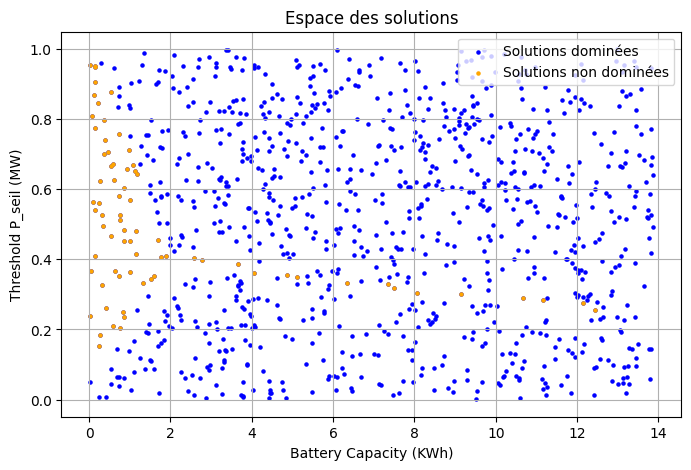

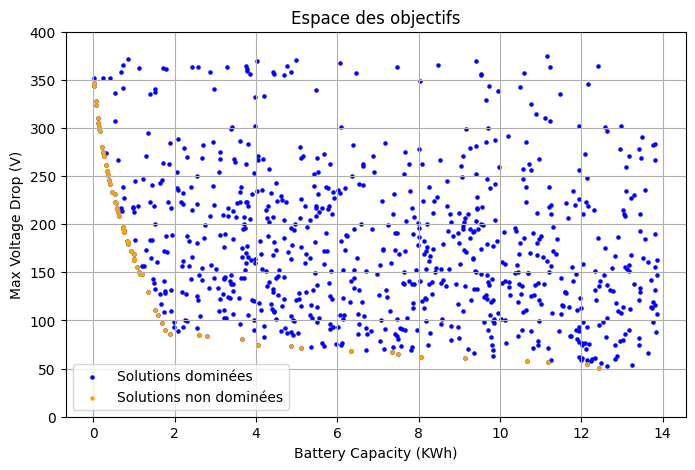

In [8]:
def plot_results(results):
    non_dominated = find_non_dominated_solutions(results)
    
    capacities = [item[0] for item in results]
    p_seuils = [item[1] for item in results]
    voltage_drops = [item[2] for item in results]
    
    non_dom_capacities = [item[0] for item in non_dominated]
    non_dom_p_seuils = [item[1] for item in non_dominated]
    non_dom_voltage_drops = [item[2] for item in non_dominated]
    
    capacities_kWh = np.array(capacities) / (3600 * 1000.0)
    p_seuils_MW = np.array(p_seuils) / 1e6
    non_dom_capacities_kWh = np.array(non_dom_capacities) / (3600 * 1000.0)
    non_dom_p_seuils_MW = np.array(non_dom_p_seuils) / 1e6

    # -----------------------------------
    # Figure 1: Plot of P_seuil vs. capacity
    # -----------------------------------
    plt.figure(figsize=(8, 5))
    # Plot all solutions in blue
    plt.scatter(capacities_kWh, p_seuils_MW, c='blue', s=5, label='Solutions dominées')
    # Plot non-dominated solutions in orange
    plt.scatter(non_dom_capacities_kWh, non_dom_p_seuils_MW, c='orange', s=5, label='Solutions non dominées')
    plt.title("Espace des solutions")
    plt.xlabel("Battery Capacity (KWh)")
    plt.ylabel("Threshold P_seil (MW)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # -----------------------------------
    # Figure 2: Plot of max voltage drop vs. capacity
    # -----------------------------------
    plt.figure(figsize=(8, 5))
    plt.scatter(capacities_kWh, voltage_drops, c='blue', s=5, label='Solutions dominées')
    plt.scatter(non_dom_capacities_kWh, non_dom_voltage_drops, c='orange', s=5, label='Solutions non dominées')
    plt.title("Espace des objectifs")
    plt.xlabel("Battery Capacity (KWh)")
    plt.ylabel("Max Voltage Drop (V)")
    plt.ylim(0, 400)
    plt.grid(True)
    plt.legend()
    plt.show()
0
plot_results(results)

# NSGA II with pymoo (creators library)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     19 |             - |             -
     2 |      200 |     34 |  0.0045024848 |         ideal
     3 |      300 |     59 |  0.0113499915 |             f
     4 |      400 |     93 |  0.0143757659 |         ideal
     5 |      500 |    100 |  0.0020135372 |             f
     6 |      600 |    100 |  0.0353837656 |         nadir
     7 |      700 |    100 |  0.0020618717 |             f
     8 |      800 |    100 |  0.0069519618 |         ideal
     9 |      900 |    100 |  0.0018565830 |             f
    10 |     1000 |    100 |  0.0042677176 |             f
    11 |     1100 |    100 |  0.0014856513 |             f
    12 |     1200 |    100 |  0.0023329348 |             f
    13 |     1300 |    100 |  0.0032288402 |             f
    14 |     1400 |    100 |  0.0025155107 |         ideal
    15 |     1500 |    100 |  0.0018888469 |             f
    16 |     1600 |    100 |  0.0029574862 |            

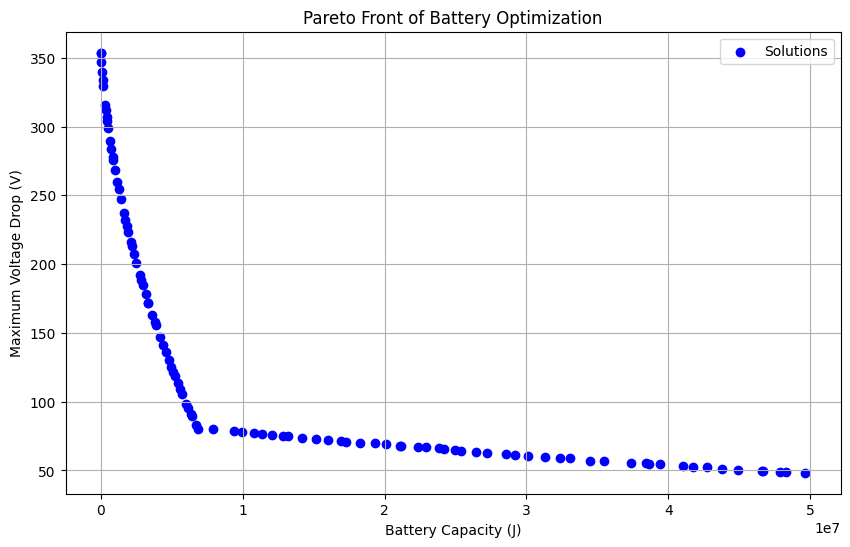

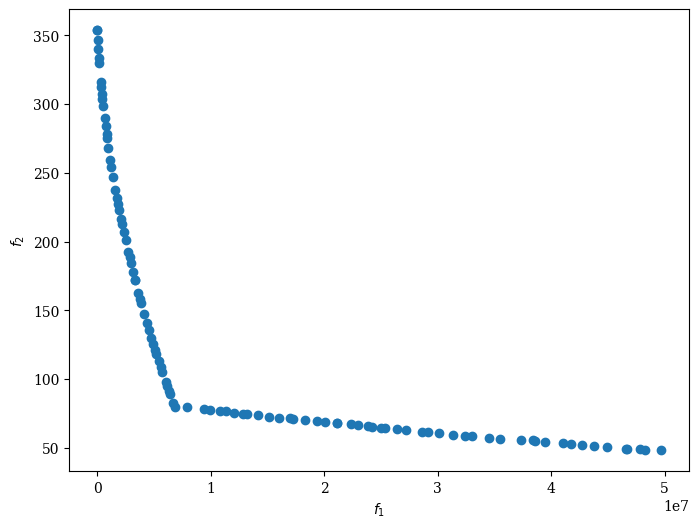

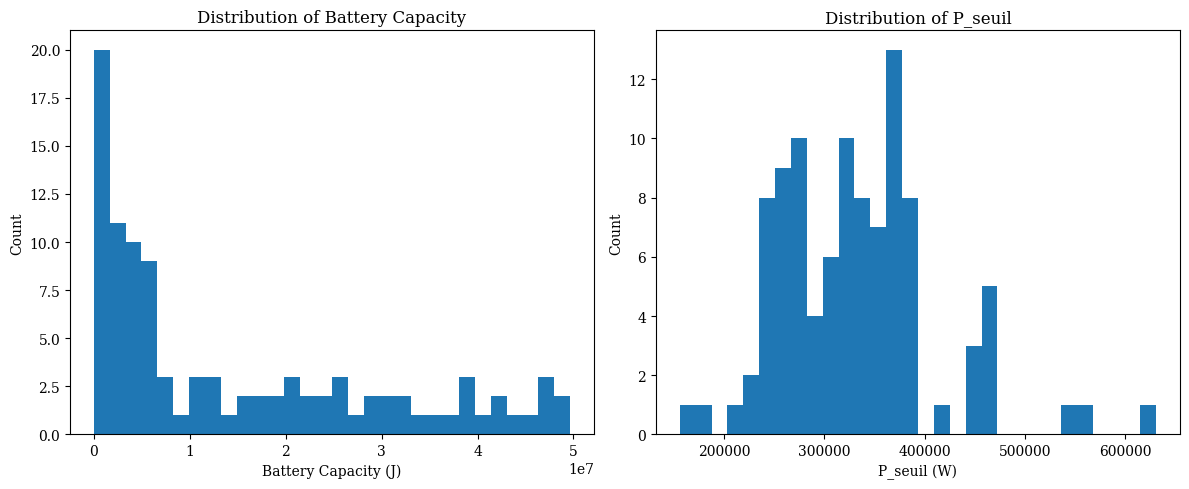

In [12]:
from pymoo.core.problem import ElementwiseProblem
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import matplotlib.pyplot as plt
from pymoo.visualization.scatter import Scatter

class BatteryOptimizationProblem(ElementwiseProblem):
    def __init__(self, temps, position_x, Ptrain, Vsst, calculer_Req, Dt, gestion_puissances):
        super().__init__(
            n_var=2,
            n_obj=2,
            xl=np.array([0, 0]),
            xu=np.array([50000000, 1000000])
        )
        self.temps = temps
        self.position_x = position_x
        self.Ptrain = Ptrain
        self.Vsst = Vsst
        self.calculer_Req = calculer_Req
        self.Dt = Dt
        self.gestion_puissances = gestion_puissances

    def _evaluate(self, x, out, *args, **kwargs):
        battery_capacity, P_seuil = x
        battery_output_capacity = battery_capacity * 0.1
        battery_input_capacity = battery_capacity * 0.1
        battery_level = battery_capacity / 2.0
        chute_de_tension_list = []

        for idx in range(len(self.temps)):
            x = self.position_x[idx]
            train_demand = self.Ptrain[idx]
            RCeq = self.calculer_Req(x)

            P_battery, P_LAC, P_rheostat, battery_level = self.gestion_puissances(
                P_seuil,
                train_demand,
                battery_level,
                battery_capacity,
                battery_output_capacity,
                battery_input_capacity,
                self.Dt
            )

            delta = self.Vsst**2 - 4 * RCeq * P_LAC
            if delta >= 0:
                Vtrain = 0.5 * (self.Vsst + np.sqrt(delta))
            else:
                Vtrain = 0

            chute_tension = self.Vsst - Vtrain
            chute_de_tension_list.append(chute_tension)

        out["F"] = np.array([battery_capacity, max(chute_de_tension_list)])

def visualize_results(results):
    # Pareto front visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(results.F[:, 0], results.F[:, 1], c='blue', label='Solutions')
    plt.xlabel('Battery Capacity (J)')
    plt.ylabel('Maximum Voltage Drop (V)')
    plt.title('Pareto Front of Battery Optimization')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Using pymoo's visualization
    plot = Scatter()
    plot.add(results.F, label="Pareto Front")
    plot.show()

    # Solutions distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.hist(results.X[:, 0], bins=30)
    ax1.set_xlabel('Battery Capacity (J)')
    ax1.set_ylabel('Count')
    ax1.set_title('Distribution of Battery Capacity')

    ax2.hist(results.X[:, 1], bins=30)
    ax2.set_xlabel('P_seuil (W)')
    ax2.set_ylabel('Count')
    ax2.set_title('Distribution of P_seuil')
    
    plt.tight_layout()
    plt.show()

def run_nsga2_optimization(temps, position_x, Ptrain, Vsst, calculer_Req, Dt, gestion_puissances):
    problem = BatteryOptimizationProblem(
        temps, position_x, Ptrain, Vsst, calculer_Req, Dt, gestion_puissances
    )

    algorithm = NSGA2(
        pop_size=100,
        n_offsprings=100
    )

    termination = ('n_gen', 100)

    res = minimize(
        problem,
        algorithm,
        termination,
        seed=1,
        save_history=True,
        verbose=True
    )

    # Visualize results
    visualize_results(res)
    
    return res

# Usage
results = run_nsga2_optimization(
    temps,
    position_x,
    Ptrain,
    Vsst,
    calculer_Req,
    Dt,
    gestion_puissances
)


# NSGA II from scratch

Génération 0
Génération 10
Génération 20
Génération 30
Génération 40
Génération 50
Génération 60
Génération 70
Génération 80
Génération 90


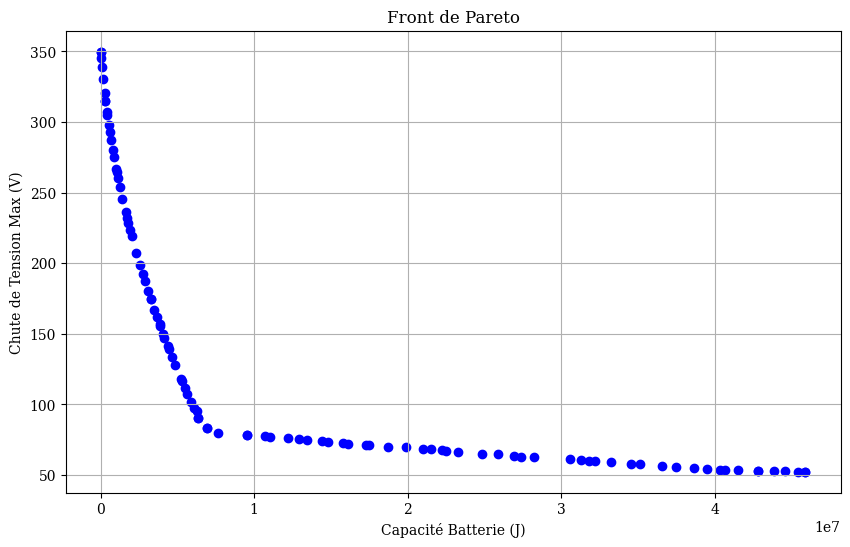

In [15]:
import numpy as np
from typing import List, Tuple
import random
import matplotlib.pyplot as plt

# Classe représentant un individu dans la population
class Individu:
    def __init__(self, x: np.ndarray):
        self.x = x  # Variables de décision
        self.objectifs = None  # Valeurs des objectifs
        self.rang = float('inf')  # Rang basé sur la domination
        self.distance_de_crowding = 0  # Distance de regroupement (crowding distance)
        self.solutions_dominees = []  # Solutions dominées par cet individu
        self.nombre_dominations = 0  # Nombre de solutions qui dominent cet individu

# Fonction principale de l'algorithme NSGA-II
def nsga2(parametres_probleme: dict, taille_pop: int, nb_generations: int, bornes: List[Tuple[float, float]]):
    # Initialisation de la population et évaluation initiale
    population = initialiser_population(taille_pop, bornes)
    for individu in population:
        individu.objectifs = evaluer_individu(individu, parametres_probleme)
    
    # Tri initial non dominé
    fronts = tri_non_domine_rapide(population)
    for front in fronts:
        calculer_distance_crowding(front)
    
    # Boucle principale des générations
    for generation in range(nb_generations):
        # Création des descendants
        descendants = []
        while len(descendants) < taille_pop:
            parent1 = selection_par_tournoi(population, 2)
            parent2 = selection_par_tournoi(population, 2)
            enfant1, enfant2 = croisement(parent1, parent2, cr=0.9)
            mutation(enfant1, bornes, mr=0.1)
            mutation(enfant2, bornes, mr=0.1)
            descendants.extend([enfant1, enfant2])
        
        # Évaluation des descendants
        for individu in descendants:
            individu.objectifs = evaluer_individu(individu, parametres_probleme)
        
        # Combinaison des populations et tri pour la prochaine génération
        population_combinee = population + descendants
        fronts = tri_non_domine_rapide(population_combinee)
        
        # Sélection de la prochaine génération
        population = []
        index_front = 0
        while index_front < len(fronts) and len(population) + len(fronts[index_front]) <= taille_pop:
            calculer_distance_crowding(fronts[index_front])
            population.extend(fronts[index_front])
            index_front += 1
        
        # Ajout des individus restants pour compléter la population
        if len(population) < taille_pop and index_front < len(fronts):
            calculer_distance_crowding(fronts[index_front])
            fronts[index_front].sort(key=lambda x: -x.distance_de_crowding)
            population.extend(fronts[index_front][:taille_pop - len(population)])
        
        # Affichage toutes les 10 générations
        if generation % 10 == 0:
            print(f"Génération {generation}")
    
    return population

# Évaluation d'un individu (calcul des objectifs)
def evaluer_individu(individu: Individu, parametres_probleme: dict) -> Tuple[float, float]:
    capacite_batterie, seuil_puissance = individu.x
    capacite_sortie = capacite_batterie * 0.1
    capacite_entree = capacite_batterie * 0.1
    niveau_batterie = capacite_batterie / 2.0
    liste_chute_tension = []
    
    for idx in range(len(parametres_probleme['temps'])):
        position_x = parametres_probleme['position_x'][idx]
        demande_train = parametres_probleme['Ptrain'][idx]
        RCeq = parametres_probleme['calculer_Req'](position_x)
        
        P_batterie, P_LAC, P_rheostat, niveau_batterie = parametres_probleme['gestion_puissances'](
            seuil_puissance,
            demande_train,
            niveau_batterie,
            capacite_batterie,
            capacite_sortie,
            capacite_entree,
            parametres_probleme['Dt']
        )
        
        delta = parametres_probleme['Vsst']**2 - 4 * RCeq * P_LAC
        if delta >= 0:
            vitesse_train = 0.5 * (parametres_probleme['Vsst'] + np.sqrt(delta))
        else:
            vitesse_train = 0
            
        chute_tension = parametres_probleme['Vsst'] - vitesse_train
        liste_chute_tension.append(chute_tension)
    
    return capacite_batterie, max(liste_chute_tension)

# Initialisation aléatoire de la population
def initialiser_population(taille_pop: int, bornes: List[Tuple[float, float]]) -> List[Individu]:
    return [Individu(np.array([random.uniform(bornes[i][0], bornes[i][1]) for i in range(len(bornes))])) 
            for _ in range(taille_pop)]

# Tri non dominé rapide
def tri_non_domine_rapide(population: List[Individu]) -> List[List[Individu]]:
    fronts = [[]]
    for p in population:
        p.solutions_dominees = []
        p.nombre_dominations = 0
        
        for q in population:
            if all(p.objectifs[i] <= q.objectifs[i] for i in range(len(p.objectifs))) and \
               any(p.objectifs[i] < q.objectifs[i] for i in range(len(p.objectifs))):
                p.solutions_dominees.append(q)
            elif all(q.objectifs[i] <= p.objectifs[i] for i in range(len(p.objectifs))) and \
                 any(q.objectifs[i] < p.objectifs[i] for i in range(len(p.objectifs))):
                p.nombre_dominations += 1
        
        if p.nombre_dominations == 0:
            p.rang = 0
            fronts[0].append(p)
    
    i = 0
    while i < len(fronts) and fronts[i]:
        prochain_front = []
        for p in fronts[i]:
            for q in p.solutions_dominees:
                q.nombre_dominations -= 1
                if q.nombre_dominations == 0:
                    q.rang = i + 1
                    prochain_front.append(q)
        i += 1
        fronts.append(prochain_front)
    
    return [front for front in fronts if front]

# Calcul de la distance de regroupement
def calculer_distance_crowding(front: List[Individu]):
    if len(front) <= 2:
        for individu in front:
            individu.distance_de_crowding = float('inf')
        return
    
    n_objectifs = len(front[0].objectifs)
    for individu in front:
        individu.distance_de_crowding = 0
    
    for m in range(n_objectifs):
        front.sort(key=lambda x: x.objectifs[m])
        front[0].distance_de_crowding = float('inf')
        front[-1].distance_de_crowding = float('inf')
        
        intervalle_objectif = front[-1].objectifs[m] - front[0].objectifs[m]
        if intervalle_objectif == 0:
            continue
            
        for i in range(1, len(front)-1):
            front[i].distance_de_crowding += (front[i+1].objectifs[m] - front[i-1].objectifs[m]) / intervalle_objectif

# Sélection par tournoi
def selection_par_tournoi(population: List[Individu], taille_tournoi: int) -> Individu:
    tournoi = random.sample(population, taille_tournoi)
    return min(tournoi, key=lambda x: (x.rang, -x.distance_de_crowding))

# Croisement entre deux parents
def croisement(parent1: Individu, parent2: Individu, cr: float) -> Tuple[Individu, Individu]:
    if random.random() < cr:
        alpha = random.random()
        enfant1_x = alpha * parent1.x + (1 - alpha) * parent2.x
        enfant2_x = (1 - alpha) * parent1.x + alpha * parent2.x
        return Individu(enfant1_x), Individu(enfant2_x)
    return Individu(parent1.x.copy()), Individu(parent2.x.copy())

# Mutation aléatoire d'un individu
def mutation(individu: Individu, bornes: List[Tuple[float, float]], mr: float):
    for i in range(len(individu.x)):
        if random.random() < mr:
            individu.x[i] = random.uniform(bornes[i][0], bornes[i][1])

# Affichage des résultats finaux
def afficher_resultats(population: List[Individu]):
    objectifs = np.array([ind.objectifs for ind in population])
    plt.figure(figsize=(10, 6))
    plt.scatter(objectifs[:, 0], objectifs[:, 1], c='blue')
    plt.xlabel('Capacité Batterie (J)')
    plt.ylabel('Chute de Tension Max (V)')
    plt.title('Front de Pareto')
    plt.grid(True)
    plt.show()

# Utilisation
bornes = [(0, 50000000), (0, 1000000)]
parametres_probleme = {
    'temps': temps,
    'position_x': position_x,
    'Ptrain': Ptrain,
    'Vsst': Vsst,
    'calculer_Req': calculer_Req,
    'Dt': Dt,
    'gestion_puissances': gestion_puissances
}

population_finale = nsga2(
    parametres_probleme=parametres_probleme,
    taille_pop=100,
    nb_generations=100,
    bornes=bornes
)

afficher_resultats(population_finale)
